In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.registration import optical_flow_ilk, optical_flow_tvl1
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from tqdm.notebook import tqdm
import os
from scipy import stats
from numpy.lib.stride_tricks import sliding_window_view
import math
from glob import glob

In [3]:
from utils.optical_flow import compute_optical_low 
from utils.stats import plot_entire_stat_tresh, analyze_hs, plot_entire_stat_mask

In [4]:
RECORD_DURATION = 100
RECORD_FPS = 5

In [5]:
# dpcca
base = 1.1
smin = 8
L = RECORD_DURATION
smax = L/2
S = []
for degree in range(int(math.log2(smin)/math.log2(base)), int(math.log2(smax)/math.log2(base))):
    new = int(base**degree)
    if not new in S:
        S.append(new)
print(S)

[7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 25, 28, 30, 34, 37, 41, 45]


In [35]:
 def video_based_frame_generator(video_path, start_frame=0, step=1, blur_sigma=None, frame_count=np.iinfo(int).max):
    cap = cv2.VideoCapture(video_path) 
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    count = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    while True:
        ret, frame = cap.read()
        if not ret or count>= frame_count:
            print("Can't receive frame (stream end?). Exiting ...")
            cap.release()
            break            
        grey_np = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        #hsv_frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        #grey_np = hsv_frame_np[...,1]
        #grey_np = cv2.resize(grey_np, (FIELD_SIZE, FIELD_SIZE), interpolation= cv2.INTER_LINEAR)
        if blur_sigma is not None:
            grey_np = gaussian_filter(grey_np, sigma=blur_sigma)
        count += step 
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        yield grey_np
    cap.release()

def frame_generator(video_path:str, start_frame=0, step=1, blur_sigma=None, frame_count=np.iinfo(int).max):
    return video_based_frame_generator(video_path, start_frame, step, blur_sigma, frame_count)

In [36]:
def get_vid_opt_flow(video_path, cache_path, start_frame=0, step=1):
    if not os.path.exists(cache_path):
        vs_np, us_np = compute_optical_low(frame_generator(video_path, blur_sigma=1, start_frame=start_frame, step=step, frame_count=RECORD_DURATION)) # 3 sec for performance
        np.savez(cache_path, vs=vs_np, us=us_np)
    else:
        with np.load(cache_path) as npzfile:
            vs_np = npzfile["vs"]
            us_np = npzfile["us"]
    return vs_np, us_np

In [37]:
def bacterial_ds_generator(video_folder, cache_folder, cache_suffix=""):
    videos = glob(os.path.join(video_folder, f"*.avi"))
    for vid in videos:
        vid_name = os.path.split(vid)[1][:-4]
        cache_path = os.path.join(cache_folder, vid_name+cache_suffix+".npz")
        yield vid, cache_path
        
for v, c in bacterial_ds_generator("./bacterial_video/", "./bacterial_video/"):
    print(v, c)

./bacterial_video\B.S.380-LA (2.2)(+)_t001.AVI ./bacterial_video/B.S.380-LA (2.2)(+)_t001.npz
./bacterial_video\pDGHtrA-LA(3)(+).avi ./bacterial_video/pDGHtrA-LA(3)(+).npz
./bacterial_video\pDG148-LA.avi ./bacterial_video/pDG148-LA.npz


# Prepare edges

In [52]:
def mean_window(data, axis):
    res = np.sum(data, axis=axis)
    return res


def std_window(data, axis):
    res = np.std(data, axis=axis)
    return res


def roll(a,      # ND array
         b_shape,      # rolling 2D window array size
         dx=1,   # horizontal step, abscissa, number of columns
         dy=1):  # vertical step, ordinate, number of rows
    """
    Rolling 2D window for ND array
    """
    shape = a.shape[:-2] + \
        ((a.shape[-2] - b_shape[-2]) // dy + 1,) + \
        ((a.shape[-1] - b_shape[-1]) // dx + 1,) + \
        b_shape  # sausage-like shape with 2D cross-section
    strides = a.strides[:-2] + \
        (a.strides[-2] * dy,) + \
        (a.strides[-1] * dx,) + \
        a.strides[-2:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def sliding_window(data, win_shape, fcn, dx=1, dy=1):
    n = data.ndim  # number of dimensions
    # np.all over 2 dimensions of the rolling 2D window for 4D array
    result = fcn(roll(data, win_shape, dx, dy), axis=(n, n+1))
    return result


def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides
    # view a as larger 4D array
    x = np.lib.stride_tricks.as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0))
    return x.reshape(r*b0, c*b1)                      # create new 2D array


def edge_density(img_np: np.array,
                 win_size: int,
                 win_step: int = 10) -> np.array:
    """Method is implemented algorithm for local edge density estimation, 
    proposed in "Sinitca, A. M., Kayumov, A. R., Zelenikhin, P. V., 
    Porfiriev, A. G., Kaplun, D. I., & Bogachev, M. I. (2023). 
    Segmentation of patchy areas in biomedical images based on local edge
    density estimation. Biomedical Signal Processing and Control, 79, 104189."

    https://www.sciencedirect.com/science/article/abs/pii/S1746809422006437

    Args:
        img_np (np.array): Gray scale image
        win_size (int): Size of averaging windows
        win_step (int, optional): Step for windows sliding. Defaults to 10.
        canny_1 (float, optional): 1st threshold for canny. Defaults to 41.
        canny_2 (float, optional): 2nd threshold for canny. Defaults to 207.

    Returns:
        np.array: Edge dencity map
    """
    dxy = win_step
    ddepth = cv2.CV_16S
    mid = cv2.Sobel(img_np, ddepth, 1, 1, ksize=5)
    mid = cv2.convertScaleAbs(mid)
    
    result = sliding_window(mid, (win_size, win_size),
                            mean_window, dx=dxy, dy=dxy) // ((win_size*win_size))
    result = tile_array(result, dxy, dxy)
    
    h_pad = img_np.shape[0] - result.shape[0]
    w_pad = img_np.shape[1] - result.shape[1]
    result = np.pad(result, ((
        h_pad//2, h_pad//2+img_np.shape[0] % 2), (w_pad//2, w_pad//2+img_np.shape[1] % 2)), 'edge')

    
    return result

In [53]:
def compute_edges_flow(generator,
                 win_size: int,
                 win_step: int = 10):
    edges = []
    image0 = None
    for frame_np in tqdm(generator):
        clear_output(wait=True)
        #Build masked Image
        edge_density_np = edge_density(frame_np, win_size, win_step)
        edges.append(edge_density_np)
        break
    return np.array(edges)

In [54]:
def get_vid_edges_flow(video_path, 
                       cache_path, 
                       start_frame=0, 
                       step=1,
                       win_size=50,
                       win_step = 10):
    if not os.path.exists(cache_path):
        edges = compute_edges_flow(frame_generator(video_path, start_frame=start_frame, step=step, frame_count=RECORD_DURATION),
                                         win_size,
                                         win_step = 10) 
        np.savez(cache_path, edges=edges)
    else:
        with np.load(cache_path) as npzfile:
            edges = npzfile["edges"]
    return edges

In [55]:
for v, c in bacterial_ds_generator("./bacterial_video/", "./bacterial_video/", cache_suffix="_edges"):
    print(v, c)

./bacterial_video\B.S.380-LA (2.2)(+)_t001.AVI ./bacterial_video/B.S.380-LA (2.2)(+)_t001_edges.npz
./bacterial_video\pDGHtrA-LA(3)(+).avi ./bacterial_video/pDGHtrA-LA(3)(+)_edges.npz
./bacterial_video\pDG148-LA.avi ./bacterial_video/pDG148-LA_edges.npz


## Estimate Optical Flow Stats with masking

./bacterial_video\B.S.380-LA (2.2)(+)_t001.AVI ./bacterial_video/B.S.380-LA (2.2)(+)_t001.npz
vector_field (99, 1040, 1388)
vector_field_std (98,)
-19.503769 -0.0004221797 20.31845
vector_field_std (96,)
-4.491456 -0.0004221797 2.8664901


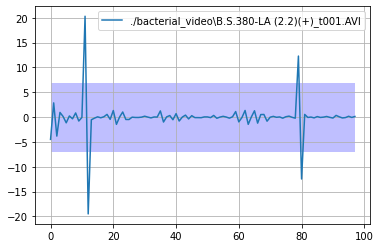

  0%|          | 0/19 [00:00<?, ?it/s]

S=11; Err=0.035
S=13; Err=0.029
S=14; Err=0.024
S=15; Err=0.024
S=17; Err=0.023
S=19; Err=0.026
S=21; Err=0.028
S=23; Err=0.031
S=25; Err=0.036
S=28; Err=0.047
S=30; Err=0.065
Opt S = 17; H_l(S) = 0.7385378391266233; H_h(S) = 0.5606116490564622
LinregressResult(slope=0.7385378391266233, intercept=0.02227820972559935, rvalue=0.9998390286841348, pvalue=1.0426368211407661e-11, stderr=0.005410517521093928, intercept_stderr=0.0055647210940076635)


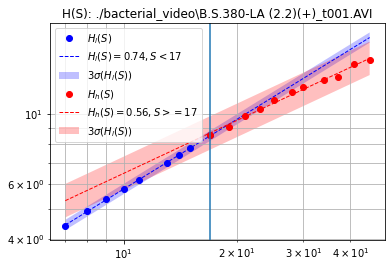

In [75]:
from scipy.stats import circstd, circvar

H_fish = []
cut_point = 0
temp = None
THRESH = 0.5
for (v, c), (v_, edges_c) in zip(bacterial_ds_generator("./bacterial_video/", "./bacterial_video/"),
                                bacterial_ds_generator("./bacterial_video/", "./bacterial_video/", cache_suffix="_edges")):
    print(v, c)
    vs_np, us_np = get_vid_opt_flow(v, c)
    edges = get_vid_edges_flow(v, edges_c, win_size=50, win_step = 25)[1:]

    vector_field = vs_np + 1j * us_np
    mask = edges>np.quantile(edges, 0.3)
    
    # plt.figure()
    # plt.imshow(mask[0])
    # plt.axis('off')
    # plt.plot()
    
    #plot_entire_stat_mask((vs_np.shape[1],vs_np.shape[2]), vs_np, us_np, mask=mask)
    
    #####################
#     v_mean = vs_np[0]
#     u_mean = us_np[0]
#     v_mean[np.invert(mask[0])] =  np.nan
#     u_mean[np.invert(mask[0])] =  np.nan
    
#     # --- Compute flow magnitude
#     norm = np.sqrt(v_mean ** 2 + u_mean ** 2)
#     # --- Display
#     plt.figure(figsize=(8, 8))
#     # --- Quiver plot arguments

#     nvec = 25  # Number of vectors to be displayed along each image dimension
#     print(vs_np.shape)
#     nl, nc = vs_np.shape[1:]
#     step = max(nl//nvec, nc//nvec)

#     y, x = np.mgrid[:nl:step, :nc:step]
#     u_ = u_mean[::step, ::step]
#     v_ = v_mean[::step, ::step]

#     plt.imshow(norm)
#     plt.quiver(x, y, u_, v_, color='r', units='dots',
#                angles='xy', scale_units='xy', lw=3)
#     plt.title("Optical flow magnitude and vector field")
#     plt.axis('off')
#     plt.tight_layout()

#     plt.show()
#     break
    #####################
    vector_field = vs_np + 1j * us_np
    
    #vector_field[mask] =  np.nan # Experiment for BG std
    
    print("vector_field", vector_field.shape)
    vector_field_std = np.diff(np.var(vector_field, axis=(1,2)))
    print("vector_field_std", vector_field_std.shape)
    print(np.nanmin(vector_field_std), np.nanmedian(vector_field_std), np.nanmax(vector_field_std))
    
    plt.figure()
    
    # Original stats
    std_ = np.std(vector_field_std)
    mean_ = np.mean(vector_field_std)
    plt.fill_between(range(len(vector_field_std)), mean_+2*std_, mean_-2*std_, facecolor='blue', alpha=0.25)
    plt.plot(vector_field_std, label=v)
    
    
    # remove and replot
    
    candidate_top = np.argwhere(vector_field_std> mean_ + 2*std_).flatten()
    candidate_bottom = np.argwhere(vector_field_std < mean_ - 2*std_).flatten()
    # print(candidate_top, candidate_bottom)
    
    to_remove = set(candidate_top+1) & set(candidate_bottom)
    # print(to_remove) 
    
    # Remove
    vector_field = np.delete(vector_field, list(to_remove), 0)
    
    # vector_field = np.cumsum(vector_field, axis=0)
    mask = np.delete(mask, list(to_remove), 0)
    
    # print("vector_field", vector_field.shape)
    vector_field_std = np.diff(np.var(vector_field, axis=(1,2)))
    print("vector_field_std", vector_field_std.shape)
    print(np.nanmin(vector_field_std), np.nanmedian(vector_field_std), np.nanmax(vector_field_std))
    std_ = np.std(vector_field_std)
    mean_ = np.mean(vector_field_std)
    # plt.fill_between(range(len(vector_field_std)), mean_+2*std_, mean_-2*std_, facecolor='blue', alpha=0.25)
    # plt.plot(vector_field_std, label=v)
    # plt.ylim((-20,20))
    plt.legend()
    plt.grid()
    plt.show()
    
    
    vector_field[np.invert(mask)] =  np.nan
    
    
    compl_vars_ = []
    for w_size in tqdm(S):
        window = sliding_window_view(vector_field, w_size, axis=0)[::w_size//4, ...]
        #H = np.std(np.sum(window, where=edges>np.quantile(edges, 0.3), axis=-1))
        H = np.nanstd(np.sum(window, axis=-1))
        compl_vars_.append(H)
    H_fish.append(np.array(compl_vars_))
    
    cross, slope_l, slope_h = analyze_hs(compl_vars_, np.array(S), title=f"H(S): {v}")

    break
# plt.yscale("log")
# plt.legend()
# plt.show()

In [ ]:
from matplotlib.animation import FFMpegWriter
video_name = "pDGHtrA-LA(3)(+)"
vs_np, us_np = get_vid_opt_flow(f"./bacterial_video/{video_name}.AVI", f"./bacterial_video/{video_name}.npz")
edges = get_vid_edges_flow(f"./bacterial_video/{video_name}.AVI", f"./bacterial_video/{video_name}_edges.npz", win_size=50, win_step = 25)[1:]
mask = edges>np.quantile(edges, 0.3)
vs_np[np.invert(mask)] =  np.nan
us_np[np.invert(mask)] =  np.nan

low_perc = 0.1
hig_perc = 0.9
v_05 = np.nanquantile(vs_np ** 2, low_perc)# y direction    
v_95 = np.nanquantile(vs_np ** 2, hig_perc)# y direction    
u_05 = np.nanquantile(us_np ** 2, low_perc)# x direction
u_95 = np.nanquantile(us_np ** 2, hig_perc)# x direction
# --- Compute flow magnitude
magn_05 = np.sqrt(v_05 + u_05)
magn_95 = np.sqrt(v_95 + u_95)


nl, nc = vs_np.shape[1:]
nvec = 25  # Number of vectors to be displayed along each image dimension
step = max(nl//nvec, nc//nvec)


plt.style.use("ggplot")
fig = plt.figure(figsize=(15,10))
plt.axis('off')
writervideo = FFMpegWriter(fps=10) 
with writervideo.saving(fig, f"./bacterial_video/masked_optical_flow_{video_name}.mp4", 100):
    for v_np, u_np in tqdm(zip(vs_np, us_np)):
        fig.clf()
        # --- Display
        # --- Quiver plot arguments
        y, x = np.mgrid[:nl:step, :nc:step]
        u_ = u_np[::step, ::step]
        v_ = v_np[::step, ::step]

        norm = np.sqrt(v_np ** 2 + u_np ** 2)
        fig.gca().imshow(norm, vmin=magn_05, vmax=magn_95, cmap="jet")
        fig.gca().quiver(x, y, u_, v_, color='r', units='dots',
                   angles='xy', scale_units='xy', lw=3)
        writervideo.grab_frame()